## Bike Sharing Trends

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [60]:
original_dataset=pd.read_csv('./train-3.csv')
df=original_dataset.copy()

## Expolatory Data Analysis

In [61]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### There are no null values which is a good start

In [62]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

#### Segregating datetime for better insights and EDA

In [63]:
df['datetime']=pd.to_datetime(df['datetime'])


df['day']=df['datetime'].map(lambda x:x.day)
df['month']=df['datetime'].map(lambda x:x.month)
df['year']=df['datetime'].map(lambda x:x.year)
df['hour']=df['datetime'].map(lambda x:x.hour)

df.drop(labels=['datetime'], axis=1, inplace=True)

In [68]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,month,year,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,2011,4


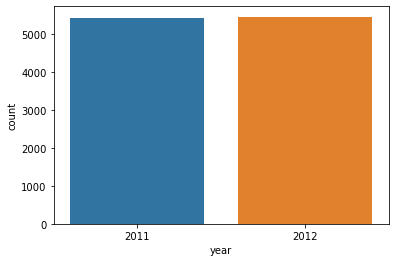

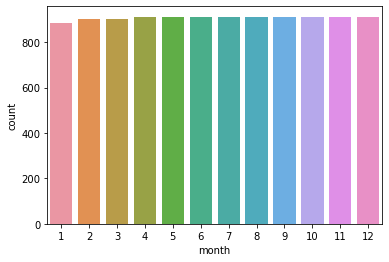

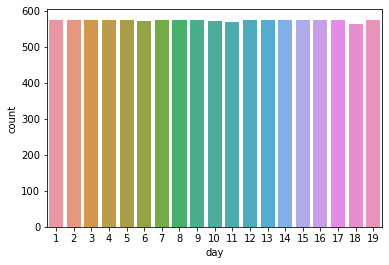

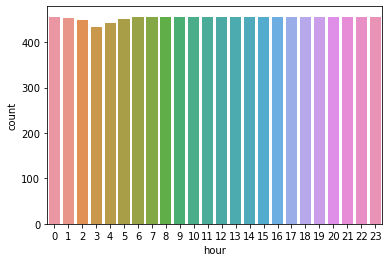

In [122]:
def countplot(df, feature):
    sns.countplot(x=df[feature])
    plt.show()

countplot(df, 'year')
countplot(df, 'month')
countplot(df, 'day')
countplot(df, 'hour')

- In both the years same number of cycles were taken
- In January slightly less cycles were taken
- From 1:00 AM to 4:00 AM less cycles are rented

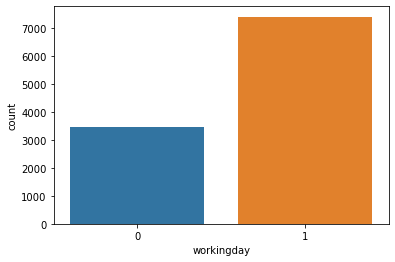

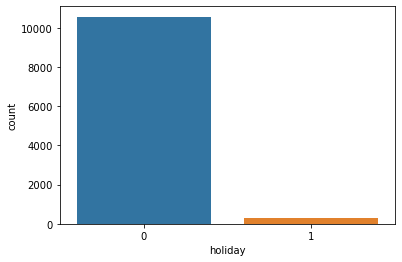

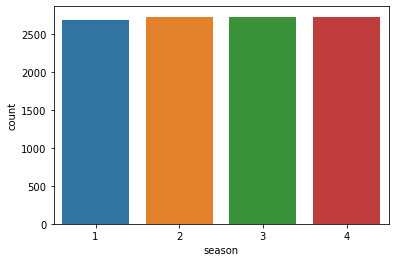

In [124]:
countplot(df,'workingday')
countplot(df, 'holiday')
countplot(df, 'season')


- We can clearly see that poeple are renting bycycles as a transport to commute to work, school, universities and so on.<br/> They are not using it  as means to have fun in the cycles with friends and families on weekends and holidays.


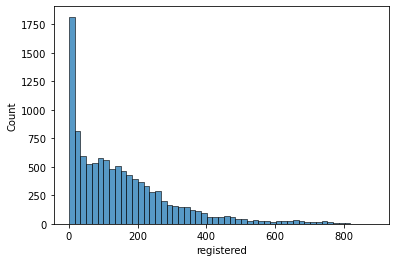

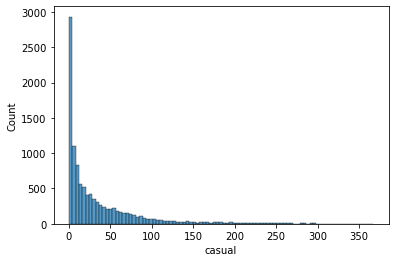

In [130]:
def hist(df, feature):
    sns.histplot(x=df[feature])
    plt.show()

hist(df, 'registered')
hist(df, 'casual')